In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        ...
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -q albumentations
!pip install -q efficientnet_pytorch
!pip install -q catalyst

### Import Packages

In [3]:
import os
import cv2
import time
import json
# from PIL import Image 
import datetime
from pathlib import Path

import warnings
# from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.datasets as datasets

from efficientnet_pytorch import EfficientNet

import albumentations as A
from albumentations.pytorch import ToTensorV2

from catalyst.data.sampler import BalanceClassSampler
from torch.utils.data.sampler import SequentialSampler

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore",category=UserWarning)
SEED=42
%matplotlib inline

### Read datasets

In [4]:
df=pd.read_csv("../input/signlanguage/datasets/Train.csv")
df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love


In [5]:
def convert(df):
    SignDict={"Seat":0,"Enough/Satisfied":1,"Mosque":2,"Temple":3,"Friend":4,"Me":5,"Church":6,"You":7,"Love":8}
    df['Label']=df['Label'].apply(lambda x:SignDict[str(x)])
    return df['Label']
    

In [6]:
convert(df)

0       3
1       6
2       1
3       5
4       8
       ..
6244    8
6245    6
6246    0
6247    7
6248    5
Name: Label, Length: 6249, dtype: int64

In [7]:
df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,3
1,ImageID_V5POEX4O,6
2,ImageID_89CCCCW6,1
3,ImageID_GNJXOWX5,5
4,ImageID_7Q9LOP7R,8


### EDA

In [8]:
df.shape

(6249, 2)

In [9]:
df['Label'].value_counts()

1    695
2    695
0    695
3    694
6    694
5    694
8    694
7    694
4    694
Name: Label, dtype: int64

### Get Model

In [10]:
def Net(model_name='b3',output=9):
    model=EfficientNet.from_pretrained(f'efficientnet-{model_name}')
    model._fc=nn.Linear(in_features=model._fc.in_features,
                        out_features=output,bias=True)
    return model                    

In [11]:
Net()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth


  0%|          | 0.00/47.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

### DataLoader

In [12]:
class DatasetRetriever(Dataset):

    def __init__(self, image_ids, labels, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = cv2.imread(f'../input/signlanguage/datasets/Images/{image_id}.jpg', cv2.IMREAD_COLOR)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        label = self.labels[idx]

        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image, label

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def get_labels(self):
        return list(self.labels)


### Image Augumentations 
###### scope of improvement

In [13]:
def train_augmentations(img_size=512):
    return A.Compose([
        A.Resize(height=img_size, width=img_size, p=1),
        A.RandomSizedCrop(min_max_height=(int(img_size-0.2*img_size), int(img_size-0.2*img_size)),
                          height=img_size, width=img_size, p=0.5),  
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.CoarseDropout(max_holes=8, max_width=12,
                        max_height=12, fill_value=0, p=0.5),
        ToTensorV2(p=1.0),
    ], p=1.0)


def validation_augumentations(img_size=512):
    return A.Compose([
        A.Resize(height=img_size, width=img_size, p=1.0),
        ToTensorV2(p=1.0),
    ], p=1.0)


1


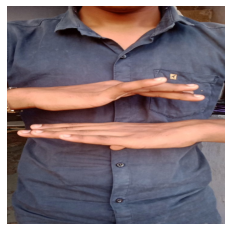

In [14]:
#3,512,512
#512,512,3

obj = DatasetRetriever(df.img_IDS.values, df.Label.values,
                       validation_augumentations())
images, labels = obj[6003]
plt.imshow(images.numpy().transpose(1, 2, 0))
plt.axis('off')
print(labels)


### Configuration
###### improvement

In [15]:
class Config:
    output=5
    num_workers=4
    batch_size=32

    img_size=224
    n_epochs=200
    lr=0.0003
    patience=5

    SchedulerClass=torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params=dict(
        mode='min',
        factor=0.8,
        patience=1,
        verbose=True,
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0,
        min_lr=1e-8,
        eps=1e-08
    )

### TrainLoader

### Helper Function
###### best practices

In [16]:
train_loss=dict()
valid_loss=dict()

class Train:
    
    def __init__(self,model,device,config,fold,model_name='b0',image_size=384, weight_path='./'):
  
        self.model=model
        self.device=device
        self.config=config
        self.best_score=0
        self.best_loss=5000
        self.fold=fold
        self.model_name = model_name
        self.image_size = image_size
        self.weight_path = weight_path
        

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.lr)

        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        
    def fit(self,train_loader,validation_loader):
        for epoch in range(self.config.n_epochs):

            print("Training Started...")
            t=time.time()
            Loss = self.train_one_epoch(train_loader)
            train_loss[epoch] = Loss.avg

            print(f'Train : Epoch {epoch}: | Loss: {Loss.avg} | Training time: {time.time()-t}')
            
            t=time.time()
            print("Validation Started...")
            loss = self.validation(validation_loader)
            valid_loss[epoch] = Loss.avg

            print(f'Valid : Epoch {epoch}: | Loss: {Loss.avg} | Training time: {time.time()-t}')
            
            self.scheduler.step(metrics=Loss.avg)
            
            if not self.best_score:
                self.best_score = Loss.avg
                print(f'Saving model with best CE Loss as {self.best_score}')
                self.model.eval()   
                patience = self.config.patience
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},  f"{self.weight_path}/{self.image_size}_{self.model_name}_{self.fold}.pt")
                continue  

            if Loss.avg <= self.best_score:
                self.best_score = Loss.avg
                patience = self.config.patience
                print('Improved model with best CE loss as {}'.format(self.best_score))
                torch.save({'model_state_dict': self.model.state_dict(),'best_score': self.best_score, 'epoch': epoch},  f"{self.weight_path}/{self.image_size}_{self.model_name}_{self.fold}.pt")
            else:
                patience -= 1
                print('Patience Reduced')
                if patience == 0:
                    print(f'Early stopping. Best CE Loss: {self.best_score}')
                    break
                    
    def validation(self, val_loader):
        self.model.eval()
        Loss = AverageMeter()

        t = time.time()

        for steps,(images, targets) in enumerate(tqdm(val_loader)):
            with torch.no_grad():
                targets = targets.to(self.device, dtype=torch.long)
                batch_size = images.shape[0]               
                images = images.to(self.device, dtype=torch.float32)
                outputs = self.model(images)
                loss = self.criterion(outputs, targets)
                Loss.update(loss.detach().item(), batch_size)
        return Loss

    def train_one_epoch(self, train_loader):
        self.model.train()

        Loss = AverageMeter()

        t = time.time()

#         print("hello before vala")
        for steps,(images, targets) in enumerate(tqdm(train_loader)):
#             print(targets)
#             print("hello after ")
#             targets=torch.tensor(targets)
#             print(type(targets))
            targets = torch.tensor(targets).to(self.device,dtype=torch.long)
#             print(type(targets))
            
            
            batch_size = images.shape[0]               
            images = images.to(self.device, dtype=torch.float32)

            self.optimizer.zero_grad()
            outputs = self.model(images)

            loss = self.criterion(outputs, targets)
            loss.backward()
            self.optimizer.step()

            Loss.update(loss.detach().item(), batch_size)

        return Loss
                           

### Helper Function
###### best practices

In [17]:
#this is just a good practice of calcualting and storing the values. Not a compulsion. Check ImageNet code from pytorch examples for more info
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


### Stratified KFold Spilit

In [18]:
base_dir = Path('datasets')
train_df = df
with open(f'../input/signlanguage/datasets/label_num_to_sign_map.json') as f:
    class_names = json.loads(f.read())
f.close()


In [19]:
train_df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,3
1,ImageID_V5POEX4O,6
2,ImageID_89CCCCW6,1
3,ImageID_GNJXOWX5,5
4,ImageID_7Q9LOP7R,8


In [20]:
train_df['label_name'] = train_df['Label'].apply(lambda x: class_names[str(x)])
train_df.head()

,img_IDS,Label,label_name
0,ImageID_33HMDMJ3,3,Temple
1,ImageID_V5POEX4O,6,Church
2,ImageID_89CCCCW6,1,Enough/Satisfied
3,ImageID_GNJXOWX5,5,Me
4,ImageID_7Q9LOP7R,8,Love


In [21]:
sk = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
for fold, (train, val) in enumerate(sk.split(train_df, train_df['Label'])):
    train_df.loc[val, 'fold'] = fold
train_df.fold = train_df.fold.astype(int)
train_df.fold.value_counts()

0    1563
2    1562
3    1562
1    1562
Name: fold, dtype: int64

In [22]:
train_df[train_df['fold']==0].img_IDS.values

array(['ImageID_0TEORZRD', 'ImageID_G05CRJGS', 'ImageID_23PKBRGS', ...,
       'ImageID_2V7AOAZ9', 'ImageID_E67IZXVJ', 'ImageID_TNAQU0UA'],
      dtype=object)

In [23]:
# train_df.get_labels()

### TestLoader

In [24]:
def test(fold_number=0,model_name='b3',image_size=512,weight_path='./',load_weights_path=None):
    train_X = train_df[train_df['fold'] != fold_number].img_IDS.values
    train_Y = train_df[train_df['fold'] != fold_number].Label.values
    valid_X = train_df[train_df['fold'] == fold_number].img_IDS.values
    valid_Y = train_df[train_df['fold'] == fold_number].Label.values

    train_dataset=DatasetRetriever(train_X,train_Y,train_augmentations(img_size=image_size))
    valid_dataset=DatasetRetriever(valid_X,valid_Y,validation_augumentations(img_size=image_size))

    train_loader=torch.utils.data.DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(),mode='downsampling'),
        batch_size=Config.batch_size,
        pin_memory=False,
        drop_last=True,
        num_workers=Config.num_workers,
    )
    validation_loader=torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=Config.batch_size,
        num_workers=Config.num_workers,
        shuffle=False,
        sampler=SequentialSampler(valid_dataset),
        pin_memory=False,
    )
    model=Net(model_name=model_name).cuda()
    if load_weights_path is not None:
        model.load_state_dict(torch.load(load_weights_path + f"{image_size} {model_name}_{fold_number}.pt")["model_state_dict"])
        print("Weight Loaded")
    engine = Train(model=model, device=torch.device('cuda'), config=Config, fold=fold_number,
    model_name=model_name, image_size=image_size, weight_path=weight_path)
    engine.fit(train_loader, validation_loader)

In [25]:
test(fold_number=0, model_name='b3', image_size=224)

Loaded pretrained weights for efficientnet-b3
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 0: | Loss: 1.033258467504423 | Training time: 80.38337135314941
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 0: | Loss: 1.033258467504423 | Training time: 19.85347294807434
Saving model with best CE Loss as 1.033258467504423
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 1: | Loss: 0.4202537830561808 | Training time: 67.3310649394989
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 1: | Loss: 0.4202537830561808 | Training time: 19.60977840423584
Improved model with best CE loss as 0.4202537830561808
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 2: | Loss: 0.3223835984627678 | Training time: 67.86000394821167
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 2: | Loss: 0.3223835984627678 | Training time: 18.852794885635376
Improved model with best CE loss as 0.3223835984627678
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 3: | Loss: 0.2656748941652987 | Training time: 68.03577947616577
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 3: | Loss: 0.2656748941652987 | Training time: 19.90359330177307
Improved model with best CE loss as 0.2656748941652987
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 4: | Loss: 0.20319392834471106 | Training time: 67.8657865524292
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 4: | Loss: 0.20319392834471106 | Training time: 18.787988424301147
Improved model with best CE loss as 0.20319392834471106
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 5: | Loss: 0.18372993039171379 | Training time: 67.94045734405518
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 5: | Loss: 0.18372993039171379 | Training time: 19.853036165237427
Improved model with best CE loss as 0.18372993039171379
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 6: | Loss: 0.15764683194790188 | Training time: 67.769038438797
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 6: | Loss: 0.15764683194790188 | Training time: 19.677770376205444
Improved model with best CE loss as 0.15764683194790188
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 7: | Loss: 0.15734236852635872 | Training time: 67.09667801856995
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 7: | Loss: 0.15734236852635872 | Training time: 19.611414432525635
Improved model with best CE loss as 0.15734236852635872
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 8: | Loss: 0.13652484157849867 | Training time: 66.98799061775208
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 8: | Loss: 0.13652484157849867 | Training time: 18.371322870254517
Improved model with best CE loss as 0.13652484157849867
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 9: | Loss: 0.1179726438163078 | Training time: 66.79347515106201
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 9: | Loss: 0.1179726438163078 | Training time: 19.15284013748169
Improved model with best CE loss as 0.1179726438163078
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 10: | Loss: 0.11982222457658755 | Training time: 66.85159063339233
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 10: | Loss: 0.11982222457658755 | Training time: 19.704892873764038
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 11: | Loss: 0.0975798261543251 | Training time: 68.05937790870667
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 11: | Loss: 0.0975798261543251 | Training time: 18.77245330810547
Improved model with best CE loss as 0.0975798261543251
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 12: | Loss: 0.10446561984590268 | Training time: 66.93629145622253
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 12: | Loss: 0.10446561984590268 | Training time: 19.15750813484192
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 13: | Loss: 0.1103991488160642 | Training time: 66.76897716522217
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 13: | Loss: 0.1103991488160642 | Training time: 17.95669722557068
Epoch    14: reducing learning rate of group 0 to 2.4000e-04.
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 14: | Loss: 0.06677198334922377 | Training time: 66.26090288162231
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 14: | Loss: 0.06677198334922377 | Training time: 18.85130476951599
Improved model with best CE loss as 0.06677198334922377
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 15: | Loss: 0.06621973054668522 | Training time: 66.93628931045532
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 15: | Loss: 0.06621973054668522 | Training time: 18.975416660308838
Improved model with best CE loss as 0.06621973054668522
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 16: | Loss: 0.051567303118844554 | Training time: 66.73015308380127
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 16: | Loss: 0.051567303118844554 | Training time: 18.37581729888916
Improved model with best CE loss as 0.051567303118844554
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 17: | Loss: 0.059528173311862276 | Training time: 67.2937970161438
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 17: | Loss: 0.059528173311862276 | Training time: 18.42318320274353
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 18: | Loss: 0.061060198986973 | Training time: 66.38366055488586
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 18: | Loss: 0.061060198986973 | Training time: 18.79346990585327
Epoch    19: reducing learning rate of group 0 to 1.9200e-04.
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 19: | Loss: 0.05360414486773925 | Training time: 66.86643075942993
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 19: | Loss: 0.05360414486773925 | Training time: 19.02263331413269
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 20: | Loss: 0.03972048945772806 | Training time: 65.95403027534485
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 20: | Loss: 0.03972048945772806 | Training time: 18.924845695495605
Improved model with best CE loss as 0.03972048945772806
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 21: | Loss: 0.04106536264689193 | Training time: 66.56185913085938
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 21: | Loss: 0.04106536264689193 | Training time: 19.22117018699646
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 22: | Loss: 0.03505199254938554 | Training time: 65.80020999908447
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 22: | Loss: 0.03505199254938554 | Training time: 18.10816764831543
Improved model with best CE loss as 0.03505199254938554
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 23: | Loss: 0.032088694475632645 | Training time: 66.55047702789307
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 23: | Loss: 0.032088694475632645 | Training time: 19.140479564666748
Improved model with best CE loss as 0.032088694475632645
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 24: | Loss: 0.03555454556931493 | Training time: 66.43375158309937
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 24: | Loss: 0.03555454556931493 | Training time: 18.372682809829712
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 25: | Loss: 0.025772444002030492 | Training time: 66.28979659080505
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 25: | Loss: 0.025772444002030492 | Training time: 18.96366024017334
Improved model with best CE loss as 0.025772444002030492
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 26: | Loss: 0.023376566745031448 | Training time: 66.0329761505127
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 26: | Loss: 0.023376566745031448 | Training time: 18.1623432636261
Improved model with best CE loss as 0.023376566745031448
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 27: | Loss: 0.031127813247858533 | Training time: 66.76382946968079
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 27: | Loss: 0.031127813247858533 | Training time: 19.03956437110901
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 28: | Loss: 0.03651537774995843 | Training time: 66.39835548400879
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 28: | Loss: 0.03651537774995843 | Training time: 18.497600555419922
Epoch    29: reducing learning rate of group 0 to 1.5360e-04.
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 29: | Loss: 0.03475154225940957 | Training time: 66.0770308971405
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 29: | Loss: 0.03475154225940957 | Training time: 18.76382303237915
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 30: | Loss: 0.020592146306015607 | Training time: 66.084721326828
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 30: | Loss: 0.020592146306015607 | Training time: 18.281957387924194
Improved model with best CE loss as 0.020592146306015607
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 31: | Loss: 0.026801374466804317 | Training time: 66.39856719970703
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 31: | Loss: 0.026801374466804317 | Training time: 19.413422107696533
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 32: | Loss: 0.02803579998746425 | Training time: 66.10528016090393
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 32: | Loss: 0.02803579998746425 | Training time: 18.903396129608154
Epoch    33: reducing learning rate of group 0 to 1.2288e-04.
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 33: | Loss: 0.017921412472289424 | Training time: 65.68451714515686
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 33: | Loss: 0.017921412472289424 | Training time: 18.431111574172974
Improved model with best CE loss as 0.017921412472289424
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 34: | Loss: 0.01567182010849013 | Training time: 66.29880380630493
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 34: | Loss: 0.01567182010849013 | Training time: 19.22744917869568
Improved model with best CE loss as 0.01567182010849013
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 35: | Loss: 0.016224668630058336 | Training time: 66.67842721939087
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 35: | Loss: 0.016224668630058336 | Training time: 18.633089542388916
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 36: | Loss: 0.012942699096939042 | Training time: 66.90416049957275
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 36: | Loss: 0.012942699096939042 | Training time: 18.98350191116333
Improved model with best CE loss as 0.012942699096939042
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 37: | Loss: 0.013418903708504194 | Training time: 66.40676403045654
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 37: | Loss: 0.013418903708504194 | Training time: 17.94004726409912
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 38: | Loss: 0.017886076102887234 | Training time: 66.49176669120789
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 38: | Loss: 0.017886076102887234 | Training time: 19.02418088912964
Epoch    39: reducing learning rate of group 0 to 9.8304e-05.
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 39: | Loss: 0.010670405223109275 | Training time: 66.90062880516052
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 39: | Loss: 0.010670405223109275 | Training time: 19.07163166999817
Improved model with best CE loss as 0.010670405223109275
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 40: | Loss: 0.014928648938135442 | Training time: 66.55598306655884
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 40: | Loss: 0.014928648938135442 | Training time: 18.43120813369751
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 41: | Loss: 0.010386742483019153 | Training time: 65.86195015907288
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 41: | Loss: 0.010386742483019153 | Training time: 18.678916692733765
Improved model with best CE loss as 0.010386742483019153
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 42: | Loss: 0.008464738966672672 | Training time: 66.49116158485413
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 42: | Loss: 0.008464738966672672 | Training time: 18.23626208305359
Improved model with best CE loss as 0.008464738966672672
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 43: | Loss: 0.005547877432086165 | Training time: 66.90311288833618
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 43: | Loss: 0.005547877432086165 | Training time: 18.738539934158325
Improved model with best CE loss as 0.005547877432086165
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 44: | Loss: 0.010545145971961687 | Training time: 65.47348093986511
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 44: | Loss: 0.010545145971961687 | Training time: 18.551941633224487
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 45: | Loss: 0.008794147509894946 | Training time: 65.26516342163086
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 45: | Loss: 0.008794147509894946 | Training time: 17.91339349746704
Epoch    46: reducing learning rate of group 0 to 7.8643e-05.
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 46: | Loss: 0.008895790943401377 | Training time: 64.93200945854187
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 46: | Loss: 0.008895790943401377 | Training time: 18.41007709503174
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 47: | Loss: 0.006670716824473483 | Training time: 65.47961974143982
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 47: | Loss: 0.006670716824473483 | Training time: 18.823911666870117
Epoch    48: reducing learning rate of group 0 to 6.2915e-05.
Patience Reduced
Training Started...


  0%|          | 0/146 [00:00<?, ?it/s]

Train : Epoch 48: | Loss: 0.011780088085363051 | Training time: 66.76075744628906
Validation Started...


  0%|          | 0/49 [00:00<?, ?it/s]

Valid : Epoch 48: | Loss: 0.011780088085363051 | Training time: 18.229678630828857
Patience Reduced
Early stopping. Best CE Loss: 0.005547877432086165
